In [91]:
import time
import keras

from keras.models import Model
from keras.layers import Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Add, Concatenate
from keras.layers import Dense, Conv2D, MaxPooling2D, LSTM, TimeDistributed, Reshape
import keras.backend as K
import keras.callbacks as callbacks

import pandas as pd
import numpy as np
from numpy import array
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [2]:
save_path = "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/benchmarks/"
model_name = "ir_lstm_smoothC0_v2"
kf = KFold(n_splits = 10, shuffle =True)
num_epochs = 60

In [3]:
def model_cycle():
    inputs = Input(shape=(50, 4, 1))
        
    x = Conv2D(48, kernel_size=(3,4),
                   activation='relu',
                   padding='valid')(inputs)
    x = MaxPooling2D((2,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # parallel line 1
    fx1 = Conv2D(48, kernel_size=(3,1),
                   activation='relu',
                   padding='same')(x)
    fx1 = BatchNormalization()(fx1)
    fx1 = Dropout(0.2)(fx1)
    fx1 = Conv2D(48, kernel_size=(3,1),
                   activation='relu',
                   padding='same')(fx1)
    fx1 = MaxPooling2D((2,1),padding='same')(fx1)
    fx1 = BatchNormalization()(fx1)
    fx1 = Dropout(0.2)(fx1)
    
    # parallel line 2
    fx2 = Conv2D(48, kernel_size=(11,1),
                   activation='relu',
                   padding='same')(x)
    fx2 = BatchNormalization()(fx2)
    fx2 = Dropout(0.2)(fx2)
    fx2 = Conv2D(48, kernel_size=(21,1),
                   activation='relu',
                   padding='same')(fx2)
    fx2 = MaxPooling2D((2,1),padding='same')(fx2)
    fx2 = BatchNormalization()(fx2)
    fx2 = Dropout(0.2)(fx2)
    
    # Add
    x1 = Concatenate(axis=-3)([fx1, fx2])
    x = Add()([x, x1])
    x = MaxPooling2D((2,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Reshape((K.int_shape(x)[1], K.int_shape(x)[3]))(x)
    x = LSTM(20, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='linear')(x)
    network = Model(inputs, outputs)
    network.compile(optimizer='rmsprop',
                    loss='mean_squared_error')
    return network

In [4]:
def dnaOneHot(sequence):
    seq_array = array(list(sequence))
    code = {"A": [0], "C": [1], "G": [2], "T": [3], "N": [4],
            "a": [0], "c": [1], "g": [2], "t": [3], "n": [4]}
    onehot_encoded_seq = []
    for char in seq_array:
        onehot_encoded = np.zeros(5)
        onehot_encoded[code[char]] = 1
        onehot_encoded_seq.append(onehot_encoded[0:4])
    return onehot_encoded_seq

In [5]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.process_time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.process_time() - self.epoch_time_start)

In [69]:
data_random_library = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/cycle3.txt",delimiter = ",")
X3 = []
for sequence_nt in data_random_library["Sequence"]:
    X3.append(dnaOneHot(sequence_nt))
X3 = array(X3)
X3 = X3.reshape((X3.shape[0],50,4,1))
X3_reverse = np.flip(X3,[1,2])
Y3_orig = data_random_library["C0"].values.astype(float)

In [6]:
data_tiling = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/tiling_smoothC0.csv",delimiter = ",")
X5 = []
for sequence_nt in data_tiling["x50mer"]:
    X5.append(dnaOneHot(sequence_nt))
X5 = array(X5)
X5 = X5.reshape((X5.shape[0],50,4,1))
X5_reverse = np.flip(X5,[1,2])
Y5 = data_tiling["smooth_C0"].values.astype(float)

In [7]:
data_chr5 = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_smoothC0.csv",delimiter = ",")
X6 = []
for sequence_nt in data_chr5["x50mer"]:
    X6.append(dnaOneHot(sequence_nt))
X6 = array(X6)
X6 = X6.reshape((X6.shape[0],50,4,1))
X6_reverse = np.flip(X6,[1,2])
Y6 = data_chr5["smooth_C0"].values.astype(float)

In [72]:
# m3 = np.mean(Y3)
# std3 = np.std(Y3)
# Z3 = (Y3-m3)/std3

m5 = np.mean(Y5)
std5 = np.std(Y5)
Z5 = (Y5-m5)/std5

m6 = np.mean(Y6)
std6 = np.std(Y6)
Z6 = (Y6-m6)/std6

# Tiling

In [ ]:
# #### tiling

# VALIDATION_LOSS = []
# fold_var = 1
# n = Z5.shape[0]

# fits = []
# detrend = []
# times = []
# times2 = []

# for train_index, val_index in kf.split(Z5):
#     training_X = X5[train_index]
#     training_X_reverse = X5_reverse[train_index]
#     validation_X = X5[val_index]
#     validation_X_reverse = X5_reverse[val_index]
#     training_Y = Z5[train_index]
#     validation_Y = Z5[val_index]
#     # CREATE NEW MODEL
#     model = model_cycle()
#     # CREATE CALLBACKS
#     checkpoint = callbacks.ModelCheckpoint(save_path + model_name+"_tiling_"+str(fold_var)+".h5",
#                                                     monitor='val_loss', verbose=1,
#                                                     save_best_only=True, mode='min')
#     time_callback = TimeHistory()

#     history = model.fit(training_X, training_Y,
#                         epochs=num_epochs,
#                         callbacks= [checkpoint, time_callback],
#                         validation_data=(validation_X, validation_Y))
#     model.load_weights(save_path + model_name+"_tiling_"+str(fold_var)+".h5")
#     model.save(save_path+model_name+"_tiling_"+str(fold_var),save_traces=False)
#     times.append(time_callback.times)

#     pred_Y = model.predict(training_X)
#     pred_Y = pred_Y.reshape(pred_Y.shape[0])
#     pred_Y_reverse = model.predict(training_X_reverse)
#     pred_Y_reverse = pred_Y_reverse.reshape(pred_Y_reverse.shape[0])
#     pred_Y = (pred_Y+pred_Y_reverse)/2
#     reg =  LinearRegression().fit(array(pred_Y).reshape(-1, 1), array(training_Y).reshape(-1, 1))
    
#     detrend_int = reg.intercept_
#     detrend_slope = reg.coef_
#     detrend.append([float(detrend_int), float(detrend_slope)])
    
#     start_time = time.process_time()
#     fit = model.predict(validation_X)
#     fit = fit.reshape(fit.shape[0])
#     fit_reverse = model.predict(validation_X_reverse)
#     fit_reverse = fit_reverse.reshape(fit_reverse.shape[0])
#     reverse_corr = np.corrcoef(fit, fit_reverse)[0,1]
#     fit = (fit + fit_reverse)/2
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, validation_Y)[0,1],np.mean(np.square(fit-validation_Y)),np.mean(fit),np.std(fit),reverse_corr]
#     fits.append(fit_tmp)
#     fit = detrend_int + fit * detrend_slope
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, validation_Y)[0,1],np.mean(np.square(fit-validation_Y)),np.mean(fit),np.std(fit),reverse_corr]
#     time0 = time.process_time() - start_time
#     times2.append([time0])
#     fits.append(fit_tmp)
    
#     start_time = time.process_time()
#     fit = model.predict(X6)
#     fit = fit.reshape(fit.shape[0])
#     fit_reverse = model.predict(X6_reverse)
#     fit_reverse = fit_reverse.reshape(fit_reverse.shape[0])
#     reverse_corr = np.corrcoef(fit, fit_reverse)[0,1]
#     fit = (fit + fit_reverse)/2
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, Z6)[0,1],np.mean(np.square(fit-Z6)),np.mean(fit),np.std(fit),reverse_corr]
#     fits.append(fit_tmp)
#     fit = detrend_int + fit * detrend_slope
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, Z6)[0,1],np.mean(np.square(fit-Z6)),np.mean(fit),np.std(fit),reverse_corr]
#     time0 = time.process_time() - start_time
#     times2.append([time0])
#     fits.append(fit_tmp)
    
#     K.clear_session()
#     fold_var += 1
    
# detrend = array(detrend)
# detrend = pd.DataFrame(detrend)
# detrend.to_csv(save_path +model_name+"_detrend_tiling.txt", index = False)

# fits = array(fits)
# fits = pd.DataFrame((fits))
# fits.to_csv(save_path +model_name+ "_fits_tiling.txt", index = False)

# with open(save_path +model_name+"_time_tiling.txt", "w") as file:
#     for row in times:
#         s = " ".join(map(str, row))
#         file.write(s+'\n')

# with open(save_path +model_name+"_pred_time_tiling.txt", "w") as file:
#     for row in times2:
#         s = " ".join(map(str, row))
#         file.write(s+'\n')

In [9]:
model_tiling = keras.models.load_model(save_path + model_name + "_tiling_10.h5")

2024-02-15 19:23:37.076787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [73]:
# random_pred_tiling = model_tiling.predict(X3)*std3 + m3
random_pred_tiling = model_tiling.predict(X3)

390/390 [==============================] - 1s 3ms/step


In [10]:
tiling_pred_tiling = model_tiling.predict(X5)*std5 + m5

2538/2538 [==============================] - 9s 3ms/step


In [11]:
chrv_pred_tiling = model_tiling.predict(X6)*std6 + m6

2576/2576 [==============================] - 9s 4ms/step


In [12]:
model_orig_tiling = keras.models.load_model(save_path + "deep-learning/ir_lstm_C0_new_v12" + "_tiling_10.h5")

In [13]:
Y5_orig = data_tiling["C0"].values.astype(float)
Y6_orig = data_chr5["C0"].values.astype(float)

In [70]:
random_pred_orig_tiling = model_orig_tiling.predict(X3)

390/390 [==============================] - 1s 3ms/step


In [14]:
tiling_pred_orig_tiling = model_orig_tiling.predict(X5)

2538/2538 [==============================] - 9s 3ms/step


In [15]:
chrv_pred_orig_tiling = model_orig_tiling.predict(X6)

2576/2576 [==============================] - 10s 4ms/step


In [75]:
# print(f"Random - Predicted Smooth C0 vs Observed Smooth C0: {np.corrcoef(array(random_pred_tiling).reshape(-1), Y5)[0,1]}")
print(f"Random - Predicted Original C0 vs Observed Original C0: {np.corrcoef(array(random_pred_orig_tiling).reshape(-1), Y3_orig)[0,1]}")
print(f"Random - Predicted Smooth C0 vs Observed Original C0: {np.corrcoef(array(random_pred_tiling).reshape(-1), Y3_orig)[0,1]}")
print(f"Random - Predicted Original C0 vs Predicted Smooth C0: {np.corrcoef(array(random_pred_orig_tiling).reshape(-1), array(random_pred_tiling).reshape(-1))[0,1]}")
# print(f"Random - Predicted Original C0 vs Observed Smooth C0: {np.corrcoef(array(random_pred_orig_tiling).reshape(-1), Y5)[0,1]}")

Random - Predicted Original C0 vs Observed Original C0: 0.9284673993700141
Random - Predicted Smooth C0 vs Observed Original C0: 0.9016064362251969
Random - Predicted Original C0 vs Predicted Smooth C0: 0.9386499384825208


In [16]:
print(f"Tiling - Predicted Smooth C0 vs Observed Smooth C0: {np.corrcoef(array(tiling_pred_tiling).reshape(-1), Y5)[0,1]}")
print(f"Tiling - Predicted Original C0 vs Observed Original C0: {np.corrcoef(array(tiling_pred_orig_tiling).reshape(-1), Y5_orig)[0,1]}")
print(f"Tiling - Predicted Smooth C0 vs Observed Original C0: {np.corrcoef(array(tiling_pred_tiling).reshape(-1), Y5_orig)[0,1]}")
print(f"Tiling - Predicted Original C0 vs Observed Smooth C0: {np.corrcoef(array(tiling_pred_orig_tiling).reshape(-1), Y5)[0,1]}")
print(f"Tiling - Observed Original C0 vs Observed Smooth C0: {np.corrcoef(Y5_orig, Y5)[0,1]}")

Tiling - Predicted Smooth C0 vs Observed Smooth C0: 0.9531672824662453
Tiling - Predicted Original C0 vs Observed Original C0: 0.9355746324122121
Tiling - Predicted Smooth C0 vs Observed Original C0: 0.9015182932673612
Tiling - Predicted Original C0 vs Observed Smooth C0: 0.9200645814387933
Tiling - Observed Original C0 vs Observed Smooth C0: 0.9279643534606407


In [17]:
print(f"ChrV - Predicted Smooth C0 vs Observed Smooth C0: {np.corrcoef(array(chrv_pred_tiling).reshape(-1), Y6)[0,1]}")
print(f"ChrV - Predicted Original C0 vs Observed Original C0: {np.corrcoef(array(chrv_pred_orig_tiling).reshape(-1), Y6_orig)[0,1]}")
print(f"ChrV - Predicted Smooth C0 vs Observed Original C0: {np.corrcoef(array(chrv_pred_tiling).reshape(-1), Y6_orig)[0,1]}")
print(f"ChrV - Predicted Original C0 vs Observed Smooth C0: {np.corrcoef(array(chrv_pred_orig_tiling).reshape(-1), Y6)[0,1]}")
print(f"ChrV - Observed Original C0 vs Observed Smooth C0: {np.corrcoef(Y6_orig, Y6)[0,1]}")

ChrV - Predicted Smooth C0 vs Observed Smooth C0: 0.8563939320487959
ChrV - Predicted Original C0 vs Observed Original C0: 0.7722812016603803
ChrV - Predicted Smooth C0 vs Observed Original C0: 0.7453448071115176
ChrV - Predicted Original C0 vs Observed Smooth C0: 0.8351951894452264
ChrV - Observed Original C0 vs Observed Smooth C0: 0.8627520965754527


In [90]:
# Save predictions to individual .csv files:
np.savetxt("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/"+model_name+"_random_pred_tiling.csv", random_pred_tiling)
np.savetxt("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/"+model_name+"_tiling_pred_tiling.csv", tiling_pred_tiling)
np.savetxt("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/"+model_name+"_chrv_pred_tiling.csv", chrv_pred_tiling)

In [18]:
import matplotlib.pyplot as plt

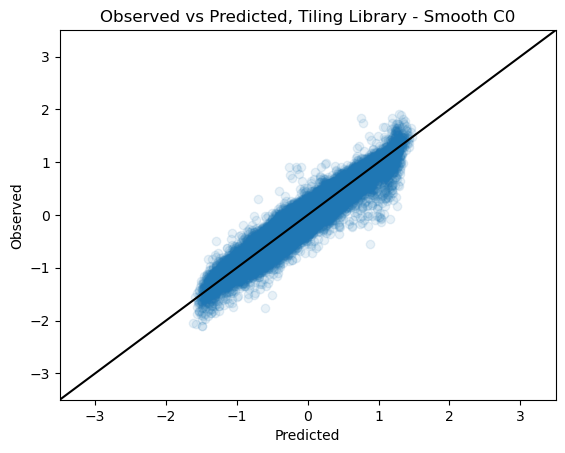

In [19]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(tiling_pred_tiling, Y5, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, Tiling Library - Smooth C0")
plt.show()

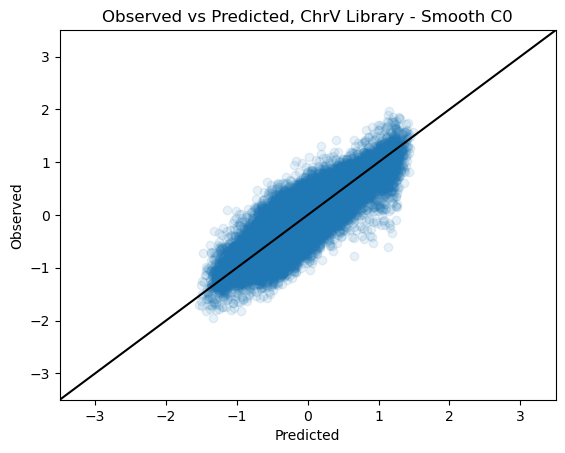

In [20]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(chrv_pred_tiling, Y6, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, ChrV Library - Smooth C0")
plt.show()

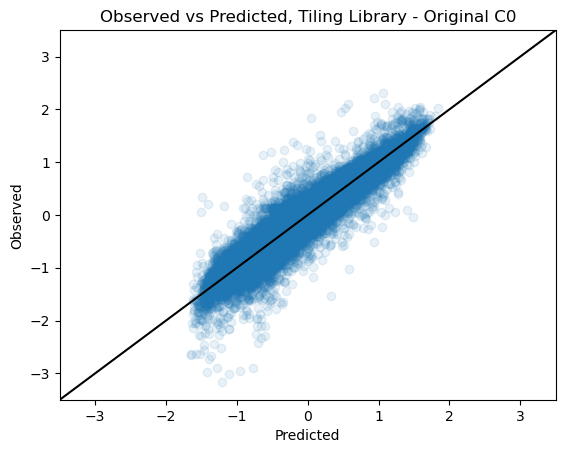

In [21]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(tiling_pred_orig_tiling, Y5_orig, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, Tiling Library - Original C0")
plt.show()

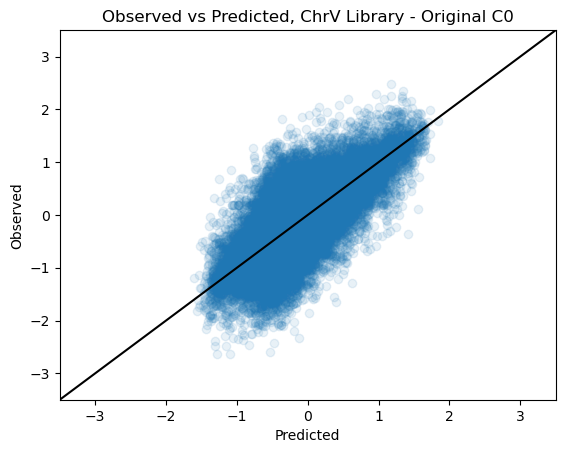

In [22]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(chrv_pred_orig_tiling, Y6_orig, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, ChrV Library - Original C0")
plt.show()

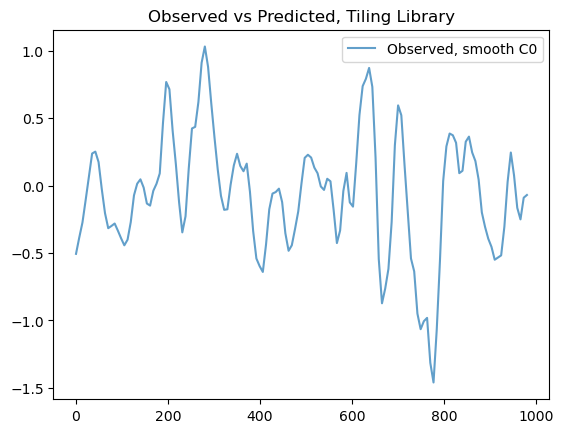

In [55]:
# x = [-3.5, 3.5]
# y = [-3.5, 3.5]
# plt.xlim(x)
# plt.ylim(y)
# plt.xlabel("Predicted")
# plt.ylabel("Observed")
# plt.plot(x, y, color="black")
# gene_number = 40
gene_number = 0
alpha_val = 0.7
# plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))], 
#          tiling_pred_tiling[(141*gene_number):(141*(gene_number+1))], label="Predicted, smooth C0", alpha=alpha_val)
plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))],
         Y5[(141*gene_number):(141*(gene_number+1))], label="Observed, smooth C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))], 
#          tiling_pred_orig_tiling[(141*gene_number):(141*(gene_number+1))], label="Predicted, original C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))],
#          Y5_orig[(141*gene_number):(141*(gene_number+1))], label="Observed, original C0", alpha=alpha_val)
plt.title("Observed vs Predicted, Tiling Library")
plt.legend()
plt.show()

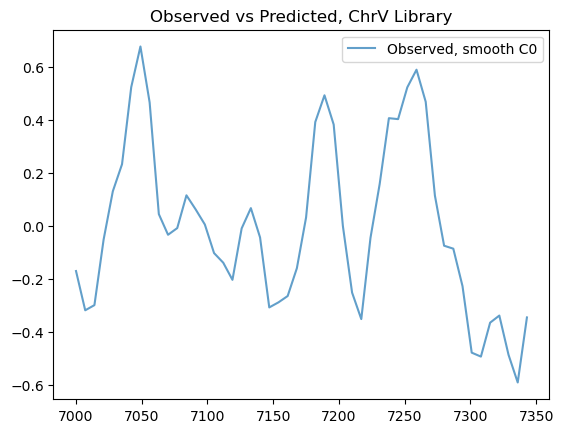

In [61]:
# x = [-3.5, 3.5]
# y = [-3.5, 3.5]
# plt.xlim(x)
# plt.ylim(y)
# plt.xlabel("Predicted")
# plt.ylabel("Observed")
# plt.plot(x, y, color="black")
starting_point = 1000
sequence_length = 50
alpha_val = 0.7
# plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)], 
#          chrv_pred_tiling[(starting_point):(starting_point+sequence_length)], label="Predicted, smooth C0", alpha=alpha_val)
plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)],
         Y6[(starting_point):(starting_point+sequence_length)], label="Observed, smooth C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)], 
#          chrv_pred_orig_tiling[(starting_point):(starting_point+sequence_length)], label="Predicted, original C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)],
#          Y6_orig[(starting_point):(starting_point+sequence_length)], label="Observed, original C0", alpha=alpha_val)
plt.title("Observed vs Predicted, ChrV Library")
plt.legend()
plt.show()

# ChrV

In [ ]:
# #### chrv

# VALIDATION_LOSS = []
# fold_var = 1
# n = Z6.shape[0]

# fits = []
# detrend = []
# times = []
# times2 = []

# for train_index, val_index in kf.split(Z6):
#     training_X = X6[train_index]
#     training_X_reverse = X6_reverse[train_index]
#     validation_X = X6[val_index]
#     validation_X_reverse = X6_reverse[val_index]
#     training_Y = Z6[train_index]
#     validation_Y = Z6[val_index]
#     # CREATE NEW MODEL
#     model = model_cycle()
#     # CREATE CALLBACKS
#     checkpoint = callbacks.ModelCheckpoint(save_path + model_name+"_chrv_"+str(fold_var)+".h5",
#                                                     monitor='val_loss', verbose=1,
#                                                     save_best_only=True, mode='min')
#     time_callback = TimeHistory()

#     history = model.fit(training_X, training_Y,
#                         epochs=num_epochs,
#                         callbacks= [checkpoint, time_callback],
#                         validation_data=(validation_X, validation_Y))
#     model.load_weights(save_path + model_name+"_chrv_"+str(fold_var)+".h5")
#     model.save(save_path+ model_name+"_chrv_"+str(fold_var),save_traces=False)
#     times.append(time_callback.times)

#     pred_Y = model.predict(training_X)
#     pred_Y = pred_Y.reshape(pred_Y.shape[0])
#     pred_Y_reverse = model.predict(training_X_reverse)
#     pred_Y_reverse = pred_Y_reverse.reshape(pred_Y_reverse.shape[0])
#     pred_Y = (pred_Y+pred_Y_reverse)/2
#     reg =  LinearRegression().fit(array(pred_Y).reshape(-1, 1), array(training_Y).reshape(-1, 1))
    
#     detrend_int = reg.intercept_
#     detrend_slope = reg.coef_
#     detrend.append([float(detrend_int), float(detrend_slope)])
    
#     start_time = time.process_time()
#     fit = model.predict(X5)
#     fit = fit.reshape(fit.shape[0])
#     fit_reverse = model.predict(X5_reverse)
#     fit_reverse = fit_reverse.reshape(fit_reverse.shape[0])
#     reverse_corr = np.corrcoef(fit, fit_reverse)[0,1]
#     fit = (fit + fit_reverse)/2
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, Z5)[0,1],np.mean(np.square(fit-Z5)),np.mean(fit),np.std(fit),reverse_corr]
#     fits.append(fit_tmp)
#     fit = detrend_int + fit * detrend_slope
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, Z5)[0,1],np.mean(np.square(fit-Z5)),np.mean(fit),np.std(fit),reverse_corr]
#     time0 = time.process_time() - start_time
#     times2.append([time0])
#     fits.append(fit_tmp)
    
#     start_time = time.process_time()
#     fit = model.predict(validation_X)
#     fit = fit.reshape(fit.shape[0])
#     fit_reverse = model.predict(validation_X_reverse)
#     fit_reverse = fit_reverse.reshape(fit_reverse.shape[0])
#     reverse_corr = np.corrcoef(fit, fit_reverse)[0,1]
#     fit = (fit + fit_reverse)/2
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, validation_Y)[0,1],np.mean(np.square(fit-validation_Y)),np.mean(fit),np.std(fit),reverse_corr]
#     fits.append(fit_tmp)
#     fit = detrend_int + fit * detrend_slope
#     fit = fit.flatten()
#     fit_tmp =[np.corrcoef(fit, validation_Y)[0,1],np.mean(np.square(fit-validation_Y)),np.mean(fit),np.std(fit),reverse_corr]
#     time0 = time.process_time() - start_time
#     times2.append([time0])
#     fits.append(fit_tmp)
    
#     K.clear_session()
#     fold_var += 1
    
# detrend = array(detrend)
# detrend = pd.DataFrame(detrend)
# detrend.to_csv(save_path +model_name+"_detrend_chrv.txt", index = False)

# fits = array(fits)
# fits = pd.DataFrame((fits))
# fits.to_csv(save_path +model_name+"_fits_chrv.txt", index = False)

# with open(save_path +model_name+"_time_chrv.txt", "w") as file:
#     for row in times:
#         s = " ".join(map(str, row))
#         file.write(s+'\n')

# with open(save_path +model_name+"_pred_time_chrv.txt", "w") as file:
#     for row in times2:
#         s = " ".join(map(str, row))
#         file.write(s+'\n')

In [26]:
model_chrv = keras.models.load_model(save_path + model_name + "_chrv_10.h5")

In [27]:
tiling_pred_chrv = model_chrv.predict(X5)*std5 + m5

2538/2538 [==============================] - 10s 4ms/step


In [28]:
chrv_pred_chrv = model_chrv.predict(X6)*std6 + m6

2576/2576 [==============================] - 9s 3ms/step


In [63]:
model_orig_chrv = keras.models.load_model(save_path + "ir_lstm" + "_chrv_10.h5")

In [64]:
Y5_orig = data_tiling["C0"].values.astype(float)
Y6_orig = data_chr5["C0"].values.astype(float)

In [65]:
tiling_pred_orig_chrv = model_orig_chrv.predict(X5)

2538/2538 [==============================] - 8s 3ms/step


In [66]:
chrv_pred_orig_chrv = model_orig_chrv.predict(X6)

2576/2576 [==============================] - 8s 3ms/step


In [67]:
print(f"Tiling - Predicted Smooth C0 vs Observed Smooth C0: {np.corrcoef(array(tiling_pred_chrv).reshape(-1), Y5)[0,1]}")
print(f"Tiling - Predicted Original C0 vs Observed Original C0: {np.corrcoef(array(tiling_pred_orig_chrv).reshape(-1), Y5_orig)[0,1]}")
print(f"Tiling - Predicted Smooth C0 vs Observed Original C0: {np.corrcoef(array(tiling_pred_chrv).reshape(-1), Y5_orig)[0,1]}")
print(f"Tiling - Predicted Original C0 vs Observed Smooth C0: {np.corrcoef(array(tiling_pred_orig_chrv).reshape(-1), Y5)[0,1]}")
print(f"Tiling - Observed Original C0 vs Observed Smooth C0: {np.corrcoef(Y5_orig, Y5)[0,1]}")

Tiling - Predicted Smooth C0 vs Observed Smooth C0: 0.9194134500782084
Tiling - Predicted Original C0 vs Observed Original C0: 0.9010163433666567
Tiling - Predicted Smooth C0 vs Observed Original C0: 0.8766160890987603
Tiling - Predicted Original C0 vs Observed Smooth C0: 0.8881931782612436
Tiling - Observed Original C0 vs Observed Smooth C0: 0.9279643534606407


In [68]:
print(f"ChrV - Predicted Smooth C0 vs Observed Smooth C0: {np.corrcoef(array(chrv_pred_chrv).reshape(-1), Y6)[0,1]}")
print(f"ChrV - Predicted Original C0 vs Observed Original C0: {np.corrcoef(array(chrv_pred_orig_chrv).reshape(-1), Y6_orig)[0,1]}")
print(f"ChrV - Predicted Smooth C0 vs Observed Original C0: {np.corrcoef(array(chrv_pred_chrv).reshape(-1), Y6_orig)[0,1]}")
print(f"ChrV - Predicted Original C0 vs Observed Smooth C0: {np.corrcoef(array(chrv_pred_orig_chrv).reshape(-1), Y6)[0,1]}")
print(f"ChrV - Observed Original C0 vs Observed Smooth C0: {np.corrcoef(Y6_orig, Y6)[0,1]}")

ChrV - Predicted Smooth C0 vs Observed Smooth C0: 0.8979316017646991
ChrV - Predicted Original C0 vs Observed Original C0: 0.8268092297953404
ChrV - Predicted Smooth C0 vs Observed Original C0: 0.7731551128169475
ChrV - Predicted Original C0 vs Observed Smooth C0: 0.8586175301083996
ChrV - Observed Original C0 vs Observed Smooth C0: 0.8627520965754527


In [ ]:
import matplotlib.pyplot as plt

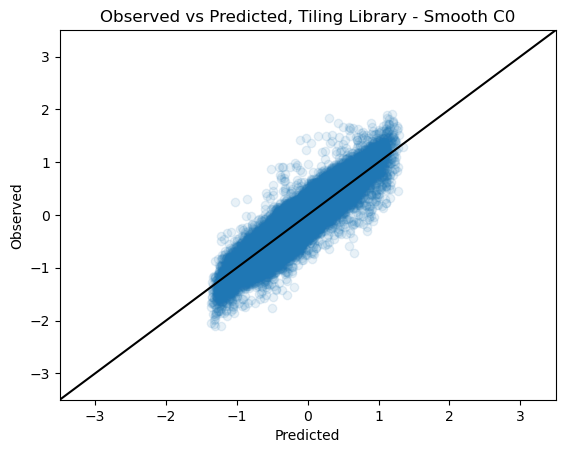

In [39]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(tiling_pred_chrv, Y5, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, Tiling Library - Smooth C0")
plt.show()

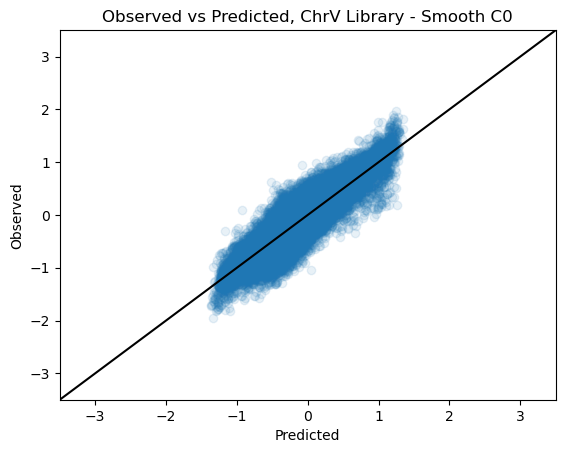

In [40]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(chrv_pred_chrv, Y6, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, ChrV Library - Smooth C0")
plt.show()

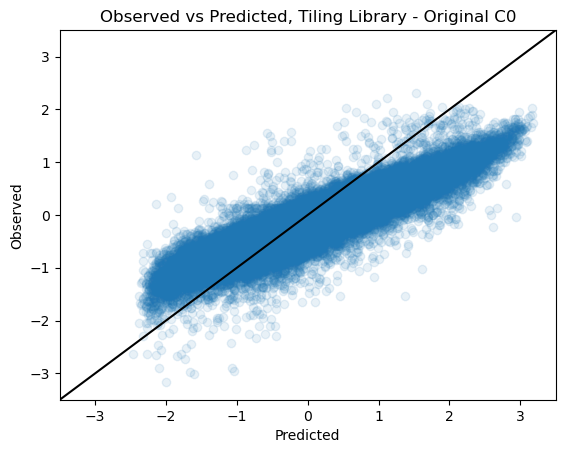

In [42]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(tiling_pred_orig_chrv, Y5_orig, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, Tiling Library - Original C0")
plt.show()

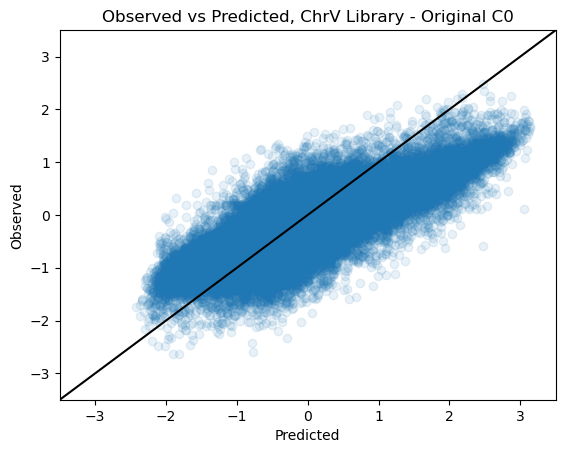

In [43]:
x = [-3.5, 3.5]
y = [-3.5, 3.5]
plt.xlim(x)
plt.ylim(y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot(x, y, color="black")
plt.scatter(chrv_pred_orig_chrv, Y6_orig, marker="o", alpha=0.1)
plt.title("Observed vs Predicted, ChrV Library - Original C0")
plt.show()

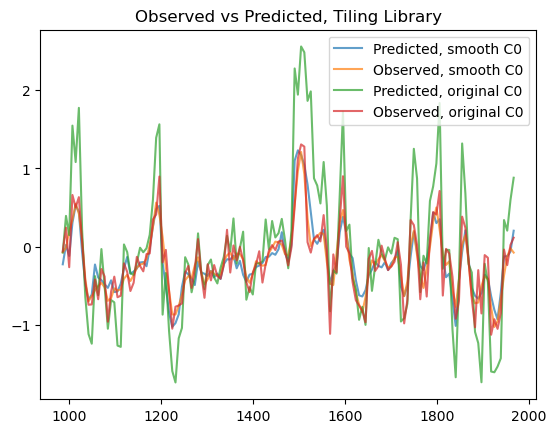

In [62]:
# x = [-3.5, 3.5]
# y = [-3.5, 3.5]
# plt.xlim(x)
# plt.ylim(y)
# plt.xlabel("Predicted")
# plt.ylabel("Observed")
# plt.plot(x, y, color="black")
# gene_number = 40
gene_number = 1
alpha_val = 0.7
plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))], 
         tiling_pred_chrv[(141*gene_number):(141*(gene_number+1))], label="Predicted, smooth C0", alpha=alpha_val)
plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))],
         Y5[(141*gene_number):(141*(gene_number+1))], label="Observed, smooth C0", alpha=alpha_val)
plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))], 
         tiling_pred_orig_chrv[(141*gene_number):(141*(gene_number+1))], label="Predicted, original C0", alpha=alpha_val)
plt.plot([i*7 for i in range(141*gene_number, 141*(gene_number+1))],
         Y5_orig[(141*gene_number):(141*(gene_number+1))], label="Observed, original C0", alpha=alpha_val)
plt.title("Observed vs Predicted, Tiling Library")
plt.legend()
plt.show()

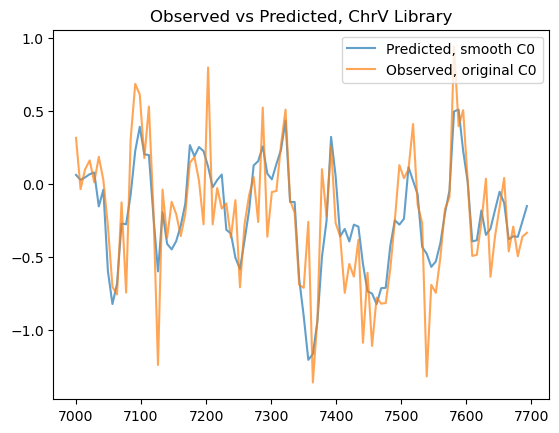

In [51]:
# x = [-3.5, 3.5]
# y = [-3.5, 3.5]
# plt.xlim(x)
# plt.ylim(y)
# plt.xlabel("Predicted")
# plt.ylabel("Observed")
# plt.plot(x, y, color="black")
starting_point = 1000
sequence_length = 100
alpha_val = 0.7
plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)], 
         tiling_pred_chrv[(starting_point):(starting_point+sequence_length)], label="Predicted, smooth C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)],
#          Y5[(starting_point):(starting_point+sequence_length)], label="Observed, smooth C0", alpha=alpha_val)
# plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)], 
#          tiling_pred_orig_chrv[(starting_point):(starting_point+sequence_length)], label="Predicted, original C0", alpha=alpha_val)
plt.plot([i*7 for i in range(starting_point, starting_point + sequence_length)],
         Y5_orig[(starting_point):(starting_point+sequence_length)], label="Observed, original C0", alpha=alpha_val)
plt.title("Observed vs Predicted, ChrV Library")
plt.legend()
plt.show()